In [21]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset,Dataset
import matplotlib.pyplot as plt
import mlflow

# Define the input tensors for stocks and sales
n = 1000
torch.manual_seed(0)
stocks = torch.randint(0, 10, (n,))
demand = torch.poisson(torch.ones(n) * 2.0)
sales = torch.min(demand, stocks)

In [51]:
def poisson_loss(predictions, sales, stocks):
   # Ensure that predictions do not exceed the stock
   predictions = torch.min(predictions, stocks)
   # Calculate the Poisson loss
   loss = torch.nn.functional.poisson_nll_loss(predictions, sales)
   return loss

def mse_loss_function(predictions,sales,stocks):
    mse_loss = nn.functional.mse_loss(predictions, sales)
    exceeded_stock_penalty = torch.mean(torch.max(predictions - stocks, torch.zeros_like(predictions)))
    loss = mse_loss + exceeded_stock_penalty
    return loss


def forecast_loss(predictions, sales, stocks, loss_function="poisson"):
    if loss_function =="poisson":
        return poisson_loss(predictions,sales,stocks)
    else:
        #mse loss by default
        return mse_loss_function(predictions,sales,stocks)
    



In [52]:
class MeanModel(nn.Module):
   def __init__(self):
       super(MeanModel, self).__init__()
       self.mean = nn.Parameter(torch.randn(1))
   def forward(self, n):
       return self.mean * torch.ones(n)

In [53]:
"""loss_function = "poisson"

experiment_name = f"experiment_{loss_function}"
if not mlflow.get_experiment_by_name(experiment_name):
   mlflow.create_experiment(experiment_name)

# Set the experiment and start a new run
mlflow.set_experiment(experiment_name)
mlflow.start_run()
"""
lr = 0.01
num_epochs = 100
optimzer_name = "SGD"
weight_decay = 1e-05
"""mlflow.log_param("learning_rate", lr)
mlflow.log_param("loss_function", loss_function)
mlflow.log_param("optimizer", "")

mlflow.log_param("num_epochs", num_epochs)
"""

'mlflow.log_param("learning_rate", lr)\nmlflow.log_param("loss_function", loss_function)\nmlflow.log_param("optimizer", "")\n\nmlflow.log_param("num_epochs", num_epochs)\n'

## comparring MSE and Poisson loss functions:

Epoch [10/100], Loss: 1.411331295967102
Epoch [20/100], Loss: 1.314740777015686
Epoch [30/100], Loss: 1.2303277254104614
Epoch [40/100], Loss: 1.1575127840042114
Epoch [50/100], Loss: 1.0955294370651245
Epoch [60/100], Loss: 1.0434623956680298
Epoch [70/100], Loss: 1.00029718875885
Epoch [80/100], Loss: 0.9517748355865479
Epoch [90/100], Loss: 0.9109905958175659
Epoch [100/100], Loss: 0.877732515335083
Epoch [10/100], Loss: 3.3061394691467285
Epoch [20/100], Loss: 2.870929002761841
Epoch [30/100], Loss: 2.580379009246826
Epoch [40/100], Loss: 2.3864057064056396
Epoch [50/100], Loss: 2.2664101123809814
Epoch [60/100], Loss: 2.19347882270813
Epoch [70/100], Loss: 2.1447885036468506
Epoch [80/100], Loss: 2.112283229827881
Epoch [90/100], Loss: 2.0905818939208984
Epoch [100/100], Loss: 2.076094150543213


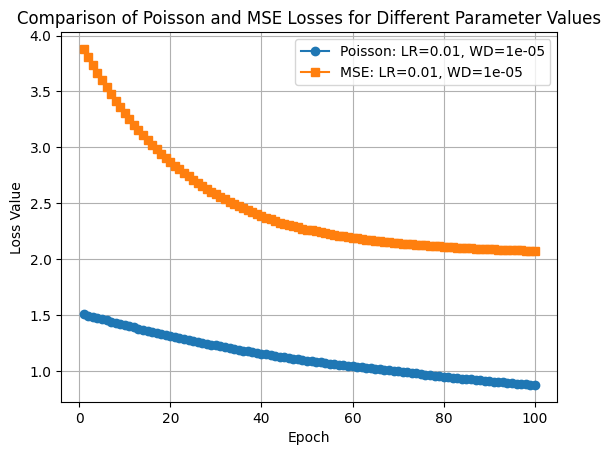

In [56]:
poisson_losses, mse_losses = [],[]
model = MeanModel()
if optimzer_name == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=lr,weight_decay=weight_decay)
if optimzer_name=="adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
else:
    raise ValueError(f"Unsupported optimizer: {optimzer_name}")

losses = []
for loss_function in ["poisson", "mse"]:
    for epoch in range(num_epochs):
   
        optimizer.zero_grad()
        outputs = model(n)
        loss = forecast_loss(outputs, sales, stocks,loss_function)
            
        loss.backward()
        optimizer.step()
        #mlflow.log_metric("loss", loss.item(), step=epoch)
        if loss_function=="poisson":
            poisson_losses.append(loss.item())
        else:
            mse_losses.append(loss.item())
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


epochs = range(1, num_epochs + 1)
# Plot Poisson losses in blue
plt.plot(epochs, poisson_losses, label=f'Poisson: LR={lr}, WD={weight_decay}', marker='o')

# Plot MSE losses in red
plt.plot(epochs, mse_losses, label=f'MSE: LR={lr}, WD={weight_decay}', marker='s')

plt.title('Comparison of Poisson and MSE Losses for Different Parameter Values')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.show()

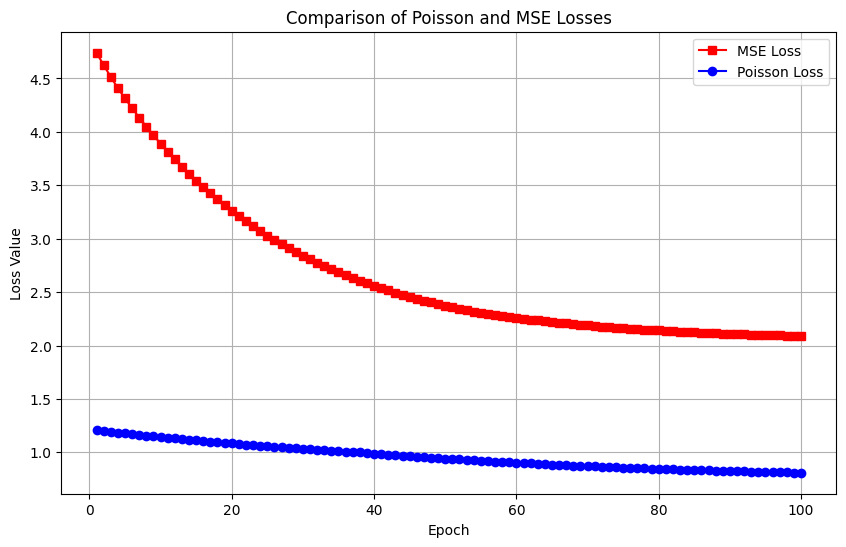

In [46]:

plt.figure(figsize=(10, 6))
poisson_losses = losses
epochs = range(1, num_epochs + 1)  # Use num_epochs directly
plt.plot(epochs, mse_losses, label='MSE Loss', color='red', marker='s')

# Plot Poisson losses in blue
plt.plot(epochs, poisson_losses, label='Poisson Loss', color='blue', marker='o')

# Plot MSE losses in red

plt.title('Comparison of Poisson and MSE Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.show()

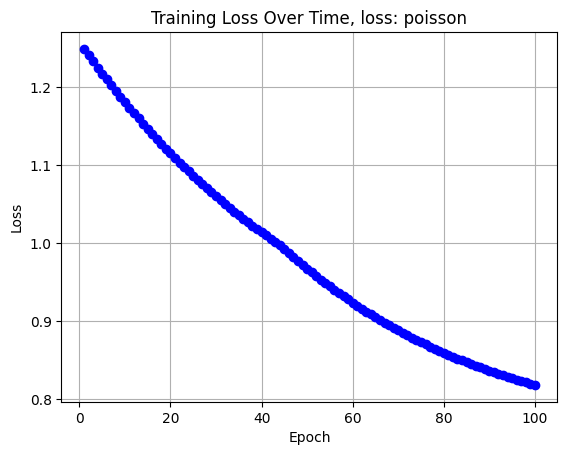

In [17]:
plt.plot(range(1, num_epochs + 1), losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training Loss Over Time, loss: {loss_function}')
plt.grid(True)
plt.show()

In [49]:
import torch
import torch.nn as nn
# Define the input tensors for stocks and sales
n = 1000
torch.manual_seed(0)
stocks = torch.randint(0, 10, (n,))
demand = torch.poisson(torch.ones(n) * 2.0)
sales = torch.min(demand, stocks)


def mse_loss(predictions,sales,stocks):
    mse_loss = nn.functional.mse_loss(predictions, sales)
    exceeded_stock_penalty = torch.mean(torch.max(predictions - stocks, torch.zeros_like(predictions)))
    loss = mse_loss + exceeded_stock_penalty
    return loss
  
class MeanModel(nn.Module):
  def __init__(self):
    super(MeanModel, self).__init__()
    self.mean = nn.Parameter(torch.randn(1))
  def forward(self, n):
    return self.mean * torch.ones(n)
import itertools

# Define hyperparameter grid
learning_rates = [0.01, 0.1, 0.001, 0.05]
weight_decays = [0.001, 0.0001, 0.00001,0.005]

best_loss = float('inf')
best_hyperparameters = {}

# Data
n = 1000
torch.manual_seed(0)
stocks = torch.randint(0, 10, (n,))
demand = torch.poisson(torch.ones(n) * 2.0)
sales = torch.min(demand, stocks)

# Training parameters
num_epochs = 50
batch_size = 32

# Perform grid search
for lr, weight_decay in itertools.product(learning_rates, weight_decays):
    model = MeanModel()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Split data into training and validation
    train_size = int(0.8 * n)
    train_stocks, train_demand, train_sales = stocks[:train_size], demand[:train_size], sales[:train_size]
    val_stocks, val_demand, val_sales = stocks[train_size:], demand[train_size:], sales[train_size:]

    # Training loop
    for epoch in range(num_epochs):
        for i in range(0, train_size, batch_size):
            batch_stocks = train_stocks[i:i + batch_size]
            batch_demand = train_demand[i:i + batch_size]
            batch_sales = train_sales[i:i + batch_size]

            optimizer.zero_grad()
            outputs = model(len(batch_stocks))
            loss = mse_loss(outputs, batch_sales, batch_stocks)
            loss.backward()
            optimizer.step()

        # Validation loop
        model.eval()
        val_outputs = model(len(val_stocks))
        val_loss = mse_loss(val_outputs, val_sales, val_stocks)

        # Update best hyperparameters if the current combination is better
        if val_loss < best_loss:
            best_loss = val_loss
            best_hyperparameters = {'lr': lr, 'weight_decay': weight_decay}

        print(f"Epoch: {epoch}, Validation Loss: {val_loss.item()}")

print("Best Hyperparameters:", best_hyperparameters)


Epoch: 0, Validation Loss: 4.104605674743652
Epoch: 1, Validation Loss: 2.9174325466156006
Epoch: 2, Validation Loss: 2.4819493293762207
Epoch: 3, Validation Loss: 2.335911273956299
Epoch: 4, Validation Loss: 2.2776846885681152
Epoch: 5, Validation Loss: 2.2534308433532715
Epoch: 6, Validation Loss: 2.2427573204040527
Epoch: 7, Validation Loss: 2.2377586364746094
Epoch: 8, Validation Loss: 2.235266923904419
Epoch: 9, Validation Loss: 2.233954668045044
Epoch: 10, Validation Loss: 2.2332324981689453
Epoch: 11, Validation Loss: 2.2328219413757324
Epoch: 12, Validation Loss: 2.23258376121521
Epoch: 13, Validation Loss: 2.23244309425354
Epoch: 14, Validation Loss: 2.2323596477508545
Epoch: 15, Validation Loss: 2.2323098182678223
Epoch: 16, Validation Loss: 2.2322797775268555
Epoch: 17, Validation Loss: 2.2322616577148438
Epoch: 18, Validation Loss: 2.232250928878784
Epoch: 19, Validation Loss: 2.2322442531585693
Epoch: 20, Validation Loss: 2.2322402000427246
Epoch: 21, Validation Loss: 2.23

In [20]:
# View the values of the trained model parameters
for name, param in model.named_parameters():
    print(f"Parameter name: {name}, Value: {param.data}")

Parameter name: mean, Value: tensor([0.3209])
